In [2]:
import numpy as np
import numpy.linalg as la
import cvxopt.solvers
import logging


MIN_SUPPORT_VECTOR_MULTIPLIER = 1e-5


class SVMTrainer(object):
    def __init__(self, kernel, c):
        self._kernel = kernel
        self._c = c

    def train(self, X, y):
        """Given the training features X with labels y, returns a SVM
        predictor representing the trained SVM.
        """
        lagrange_multipliers = self._compute_multipliers(X, y)
        return self._construct_predictor(X, y, lagrange_multipliers)

    def _gram_matrix(self, X):
        n_samples, n_features = X.shape
        K = np.zeros((n_samples, n_samples))
        # TODO(tulloch) - vectorize
        for i, x_i in enumerate(X):
            for j, x_j in enumerate(X):
                K[i, j] = self._kernel(x_i, x_j)
        return K

    def _construct_predictor(self, X, y, lagrange_multipliers):
        support_vector_indices = \
            lagrange_multipliers > MIN_SUPPORT_VECTOR_MULTIPLIER

        support_multipliers = lagrange_multipliers[support_vector_indices]
        support_vectors = X[support_vector_indices]
        support_vector_labels = y[support_vector_indices]

        # http://www.cs.cmu.edu/~guestrin/Class/10701-S07/Slides/kernels.pdf
        # bias = y_k - \sum z_i y_i  K(x_k, x_i)
        # Thus we can just predict an example with bias of zero, and
        # compute error.
        bias = np.mean(
            [y_k - SVMPredictor(
                kernel=self._kernel,
                bias=0.0,
                weights=support_multipliers,
                support_vectors=support_vectors,
                support_vector_labels=support_vector_labels).predict(x_k)
             for (y_k, x_k) in zip(support_vector_labels, support_vectors)])

        return SVMPredictor(
            kernel=self._kernel,
            bias=bias,
            weights=support_multipliers,
            support_vectors=support_vectors,
            support_vector_labels=support_vector_labels)

    def _compute_multipliers(self, X, y):
        n_samples, n_features = X.shape

        K = self._gram_matrix(X)
        # Solves
        # min 1/2 x^T P x + q^T x
        # s.t.
        #  Gx \coneleq h
        #  Ax = b

        P = cvxopt.matrix(np.outer(y, y) * K)
        q = cvxopt.matrix(-1 * np.ones(n_samples))

        # -a_i \leq 0
        # TODO(tulloch) - modify G, h so that we have a soft-margin classifier
        G_std = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
        h_std = cvxopt.matrix(np.zeros(n_samples))

        # a_i \leq c
        G_slack = cvxopt.matrix(np.diag(np.ones(n_samples)))
        h_slack = cvxopt.matrix(np.ones(n_samples) * self._c)

        G = cvxopt.matrix(np.vstack((G_std, G_slack)))
        h = cvxopt.matrix(np.vstack((h_std, h_slack)))

        A = cvxopt.matrix(y, (1, n_samples))
        b = cvxopt.matrix(0.0)

        solution = cvxopt.solvers.qp(P, q, G, h, A, b)

        # Lagrange multipliers
        r = np.ravel(solution['x'])
        
        print r
        
        return r


class SVMPredictor(object):
    def __init__(self,
                 kernel,
                 bias,
                 weights,
                 support_vectors,
                 support_vector_labels):
        self._kernel = kernel
        self._bias = bias
        self._weights = weights
        self._support_vectors = support_vectors
        self._support_vector_labels = support_vector_labels
        assert len(support_vectors) == len(support_vector_labels)
        assert len(weights) == len(support_vector_labels)
        logging.info("Bias: %s", self._bias)
        logging.info("Weights: %s", self._weights)
        logging.info("Support vectors: %s", self._support_vectors)
        logging.info("Support vector labels: %s", self._support_vector_labels)

    def predict(self, x):
        """
        Computes the SVM prediction on the given features x.
        """
        result = self._bias
        for z_i, x_i, y_i in zip(self._weights,
                                 self._support_vectors,
                                 self._support_vector_labels):
            result += z_i * y_i * self._kernel(x_i, x)
        return np.sign(result).item()

class Kernel(object):
    """Implements list of kernels from
    http://en.wikipedia.org/wiki/Support_vector_machine
    """
    @staticmethod
    def linear():
        return lambda x, y: np.inner(x, y)

    @staticmethod
    def gaussian(sigma):
        return lambda x, y: \
            np.exp(-np.sqrt(la.norm(x-y) ** 2 / (2 * sigma ** 2)))

    @staticmethod
    def _polykernel(dimension, offset):
        return lambda x, y: (offset + np.inner(x, y)) ** dimension

    @classmethod
    def inhomogenous_polynomial(cls, dimension):
        return cls._polykernel(dimension=dimension, offset=1.0)

    @classmethod
    def homogenous_polynomial(cls, dimension):
        return cls._polykernel(dimension=dimension, offset=0.0)

    @staticmethod
    def hyperbolic_tangent(kappa, c):
        return lambda x, y: np.tanh(kappa * np.dot(x, y) + c)

     pcost       dcost       gap    pres   dres
 0: -1.6281e+00 -1.8386e+00  4e+01  6e+00  2e-16
 1: -5.8755e-01 -1.6773e+00  3e+00  3e-01  5e-16
 2: -4.7879e-01 -8.1803e-01  3e-01  6e-17  4e-16
 3: -5.1624e-01 -5.6147e-01  5e-02  7e-17  3e-16
 4: -5.3324e-01 -5.4005e-01  7e-03  5e-17  2e-16
 5: -5.3662e-01 -5.3705e-01  4e-04  6e-17  2e-16
 6: -5.3679e-01 -5.3680e-01  1e-05  3e-17  2e-16
 7: -5.3679e-01 -5.3679e-01  1e-07  3e-17  3e-16
Optimal solution found.
[  9.99999992e-02   1.17668920e-08   8.17242078e-09   8.31253918e-02
   9.99999990e-02   9.99999813e-02   9.99999991e-02   1.68746263e-02
   1.26317323e-08   9.99999653e-02]
[[-1.06083048  0.39802356]
 [ 0.50550056  0.93733807]
 [ 0.27138463 -1.17178827]
 [ 0.12903297  0.35697593]
 [-0.07114667 -0.50193906]
 [-0.4351612   1.57280337]
 [ 0.65395017  0.26906029]]


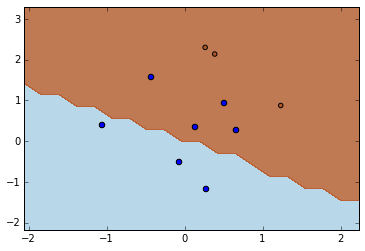

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import itertools

def plot(predictor, X, y, grid_size):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, grid_size),
                         np.linspace(y_min, y_max, grid_size),
                         indexing='ij')
    flatten = lambda m: np.array(m).reshape(-1,)

    result = []
    for (i, j) in itertools.product(range(grid_size), range(grid_size)):
        point = np.array([xx[i, j], yy[i, j]]).reshape(1, 2)
        result.append(predictor.predict(point))

    Z = np.array(result).reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 cmap=cm.Paired,
                 levels=[-0.001, 0.001],
                 extend='both',
                 alpha=0.8)
    plt.scatter(flatten(X[:, 0]), flatten(X[:, 1]),
                c=flatten(y), cmap=cm.Paired)
    
    print predictor._support_vectors
    
    svx, svy = [], []
    
    for s in predictor._support_vectors:
        svx.append(s[0, 0])
        svy.append(s[0, 1])
    
    plt.scatter(svx, svy, s=30)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    
num_samples=10
num_features=2
grid_size=20

samples = np.matrix(np.random.normal(size=num_samples * num_features)
                    .reshape(num_samples, num_features))
labels = 2 * (samples.sum(axis=1) > 0) - 1.0
trainer = SVMTrainer(Kernel.linear(), 0.1)
predictor = trainer.train(samples, labels)

plot(predictor, samples, labels, grid_size)